In [1]:
import pandas as pd
from sktime.datasets import load_gunpoint
from sktime.clustering.k_means import TimeSeriesKMeans
import seaborn as sns
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score 

c:\Users\Lavigi\programmi\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
ts = pd.read_csv("ts_approx.csv")

ts['rating_category'] = ts['rating_category'].replace('Low', 'Medium Low')

# Clustering

## Distance-based Clustering

### Euclidean

In [3]:
ts_numeric = ts.drop(columns=['id', 'rating', 'genre', 'rating_category'])

train, test = train_test_split(ts_numeric, test_size = 2, random_state = 42)

In [4]:
# !pip install tslearn
# !pip install h5py
# !pip install scikit-learn-extra

In [5]:
# from sklearn_extra.cluster import KMedoids
# from tslearn.metrics import cdist_dtw

# # Calcolo matrice di distanza DTW con vincolo Sakoe-Chiba
# dists = cdist_dtw(ts_numeric, global_constraint="sakoe_chiba", sakoe_chiba_radius=4)

# # Clustering con KMedoids
# clusterer = KMedoids(n_clusters=3, metric="precomputed", random_state=0)
# clusterer.fit(dists)
# labels = clusterer.labels_

In [6]:
clusterer = TimeSeriesKMeans(n_clusters=6, metric="euclidean", random_state=42)

In [7]:
# Convertiamo il DataFrame in un array NumPy 3D con forma (n_istanze, 1, n_timepoint)
def convert_to_numpy3D(df):
    return np.expand_dims(df.values, axis=1)

# Applichiamo la conversione
ts_numeric = convert_to_numpy3D(ts_numeric)

clusterer.fit(ts_numeric)

TimeSeriesKMeans(metric='euclidean', n_clusters=6, random_state=42)

In [8]:
clusterer.labels_

array([2, 4, 4, ..., 2, 2, 4], dtype=int64)

In [9]:
ts_numeric = pd.DataFrame(ts_numeric.reshape(1134, 50))
ts_numeric["cluster"] = clusterer.labels_
ts_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
0,5,5,5,4,3,4,2,3,4,5,...,1,1,1,1,1,1,1,1,1,2
1,5,5,5,5,2,3,3,3,4,3,...,1,1,1,2,4,3,0,1,0,4
2,5,5,5,3,3,3,5,5,5,2,...,2,2,2,2,2,2,2,2,2,4
3,5,2,2,2,1,1,3,5,2,1,...,2,2,4,4,2,2,2,2,2,5
4,5,5,5,5,5,5,5,5,4,5,...,1,1,1,1,1,1,1,1,1,1


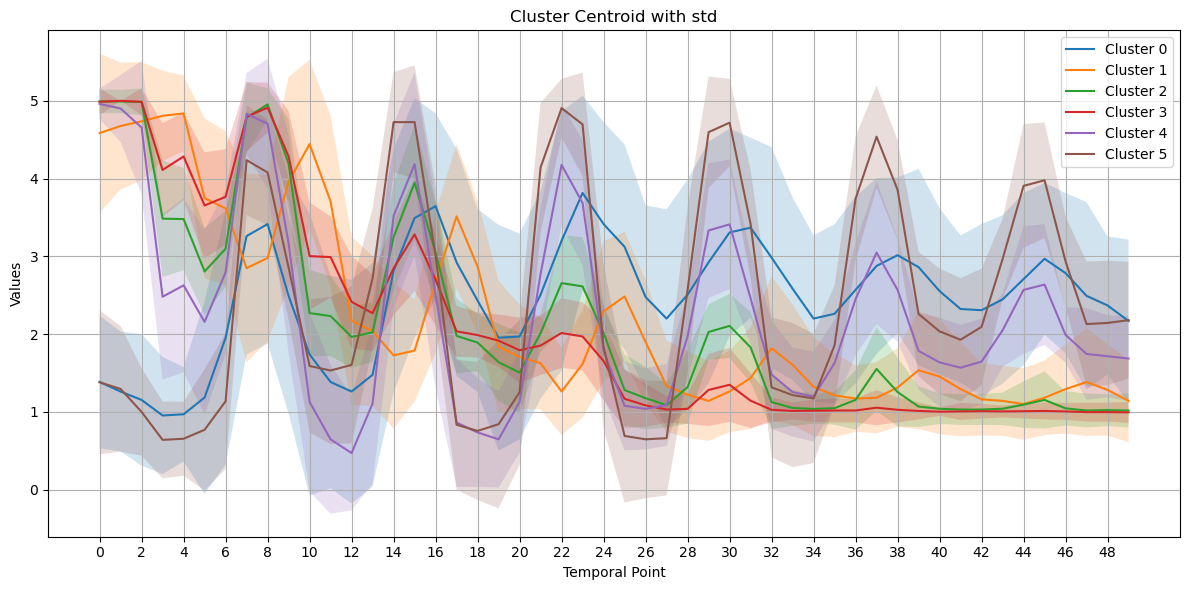

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Estrai i centroidi
centroids = clusterer.cluster_centers_

# Calcola la deviazione standard per ciascun cluster
std_devs = np.zeros_like(centroids)
for i in range(clusterer.n_clusters):
    # Estrai le serie del cluster i
    cluster_data = ts_numeric[ts_numeric["cluster"] == i].drop(columns=["cluster"]).values
    std_devs[i] = np.std(cluster_data, axis=0)

# Plot
plt.figure(figsize=(12, 6))
for i, centroid in enumerate(centroids):
    mean = centroid.flatten()
    std = std_devs[i].flatten()
    plt.plot(mean, label=f'Cluster {i}')
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)


# Imposta i tick dell'asse x ogni 2 unità
plt.xticks(ticks=np.arange(0, len(mean), 2))

plt.title('Cluster Centroid with std')
plt.xlabel('Temporal Point')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Cluster 0 inizia con valori altri, ricorrenti poi tende ad appiattirsi,  
cluster 1 parte in basso, ma poi ha picchi piu elevati, ricorrenti e continui, ha std elevata  
cluster 2 simile a cluster 0 ma traslato piu avanti  
cluster 3 simile a 0 ma si appiattisce piu rapidamente  
cluster 4 inizia in basso ma poi picchi piu elevati e traslati, ha std elevata in tutti i punti temporali 
cluster 5 inizia in basso, inizialmente ha avuto picchi piu elevati in alto e in basso  
cluster 6 inizia piu in alto, poi valori medi e piatti

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Melt del DataFrame
# df_melt = ts_numeric.melt(value_name="observation", var_name="time", id_vars="cluster")

# # Usa una palette più colorata (es. 'husl' o 'tab10')
# palette = sns.color_palette("husl", n_colors=df_melt["cluster"].nunique())

# plt.figure(figsize=(18, 6))
# # Line plot
# sns.lineplot(data=df_melt, x="time", y="observation", hue="cluster", palette=palette)
# plt.title("Clustered time series dataset (mean and std)")
# plt.show()

Questo codice serve a visualizzare l'andamento delle serie temporali raggruppate per cluster, usando colori distinti per ogni cluster. È utile per analizzare visivamente come si comportano i diversi gruppi nel tempo.

c:\Users\Lavigi\programmi\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


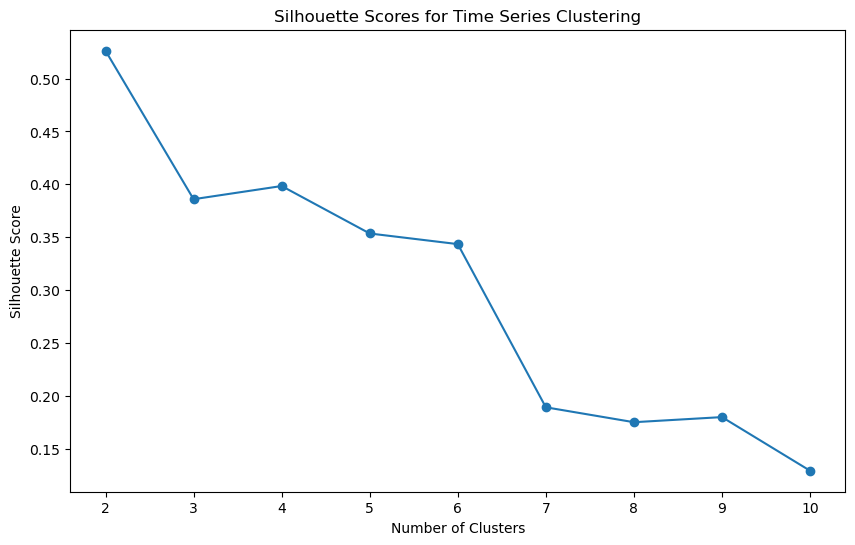

In [12]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Funzione per convertire i dati in formato 3D
def convert_to_numpy3D(data):
    return np.array(data).reshape((data.shape[0], data.shape[1], 1))

# Funzione per calcolare i silhouette score
def compute_silhouette_scores(data, min_clusters=2, max_clusters=10):
    silhouette_scores = []
    data_3d = convert_to_numpy3D(data)
    
    for k in range(min_clusters, max_clusters + 1):
        clusterer = TimeSeriesKMeans(n_clusters=k, metric="euclidean", random_state=42)
        cluster_labels = clusterer.fit_predict(data_3d)
        
        # Calcolo del silhouette score
        score = silhouette_score(data_3d.reshape(data_3d.shape[0], -1), cluster_labels, metric="euclidean")
        silhouette_scores.append(score)
    
    return silhouette_scores

# Calcolo dei silhouette score
silhouette_scores = compute_silhouette_scores(ts_numeric)

# Plot dei risultati
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Time Series Clustering')
plt.show()

In [13]:
silhouette_scores

[0.5263028155111428,
 0.3859312583277629,
 0.398386856767824,
 0.3535282208124365,
 0.3434727466781961,
 0.18920177651281447,
 0.17510390234017753,
 0.17993329623961854,
 0.12924098814778348]

é stato provato sia dtw che euclidean, ma euclidean ha portato a cluster piu separati e definiti rispetto a dtw

### Prova distribuzioni classi

In [14]:
ts["cluster"] = clusterer.labels_
ts

,id,0,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,rating,genre,rating_category,cluster
0,tt0062622,5,5,5,4,3,4,2,3,4,...,1,1,1,1,1,1,8.3,"['Adventure', 'Sci-Fi']",High,2
1,tt0064816,5,5,5,5,2,3,3,3,4,...,2,4,3,0,1,0,7.1,"['Crime', 'Drama', 'Romance']",High,4
2,tt0088178,5,5,5,3,3,3,5,5,5,...,2,2,2,2,2,2,8.7,"['Documentary', 'Music']",High,4
3,tt0145487,5,2,2,2,1,1,3,5,2,...,4,2,2,2,2,2,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,5
4,tt0359950,5,5,5,5,5,5,5,5,4,...,1,1,1,1,1,1,7.3,"['Adventure', 'Comedy', 'Drama']",High,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,5,5,5,4,4,4,4,5,5,...,1,1,1,1,1,1,6.4,"['Horror', 'Mystery', 'Thriller']",Medium,3
1130,tt9735462,5,5,5,4,5,5,4,5,5,...,1,1,1,1,1,1,6.3,"['Biography', 'Comedy', 'Drama']",Medium,3
1131,tt9764362,5,5,5,4,4,4,4,5,5,...,1,1,1,1,1,1,7.2,"['Comedy', 'Horror', 'Thriller']",High,2
1132,tt9784798,5,5,5,3,2,2,3,5,5,...,1,2,1,1,1,1,7.4,"['Biography', 'Drama', 'History']",High,2


In [15]:
ts['cluster'].unique()

array([2, 4, 5, 1, 3, 0], dtype=int64)

In [16]:
# Calcola statistiche descrittive per ciascun cluster
cluster_stats = ts.groupby('cluster').describe()

# Visualizza le statistiche
cluster_stats


0                                                   1            \
         count      mean       std  min  25%  50%  75%  max  count      mean   
cluster                                                                        
0         65.0  1.384615  0.860456  0.0  1.0  1.0  2.0  4.0   65.0  1.261538   
1         99.0  4.585859  1.030258  0.0  5.0  5.0  5.0  5.0   99.0  4.676768   
2        396.0  4.992424  0.150756  2.0  5.0  5.0  5.0  5.0  396.0  4.992424   
3        333.0  4.987988  0.173135  2.0  5.0  5.0  5.0  5.0  333.0  5.000000   
4        102.0  4.960784  0.195066  4.0  5.0  5.0  5.0  5.0  102.0  4.901961   
5        139.0  1.381295  0.927797  0.0  1.0  1.0  2.0  5.0  139.0  1.294964   

         ...   49      rating                                                 
         ...  75%  max  count      mean       std  min    25%  50%  75%  max  
cluster  ...                                                                  
0        ...  3.0  5.0   65.0  7.173846  0.600072  4.8  6.900  7.3  7.5  8.3  
1        ...  1.0  3.0   99.0  6.689899  0.907170  4.0  6.200  6.7  7.3  8.7  
2        ...  1.0  2.0  396.0  6.488889  0.895631  3.3  6.000  6.5  7.1  8.5  
3        ...  1.0  2.0  333.0  6.260661  0.882689  2.8  5.700  6.3  6.8  8.5  
4        ...  2.0  2.0  102.0  6.628431  0.856585  4.6  6.125  6.6  7.2  8.7  
5        ...  3.0  5.0  139.0  7.253237  0.540169  5.0  6.900  7.3  7.6  8.5  

[6 rows x 408 columns]

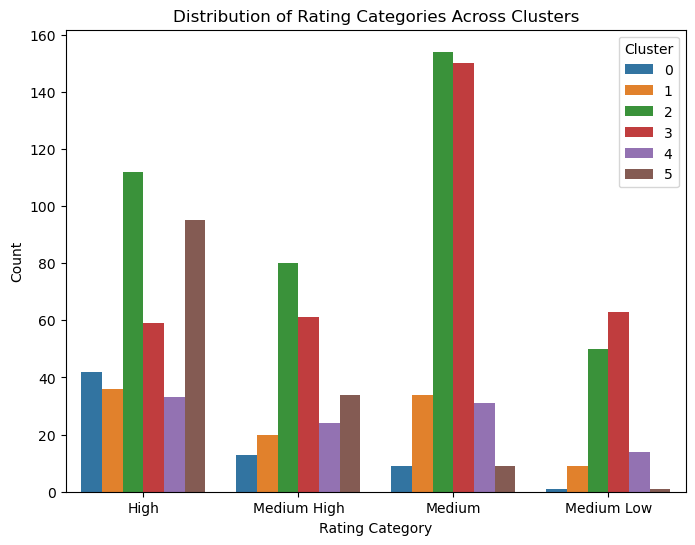

In [17]:

# Explode the 'genre' column to have one genre per row
#ts_exploded = ts.explode('rating_category')

# Plot the distribution of rating categories across clusters
plt.figure(figsize=(8, 6))
sns.countplot(data=ts, x='rating_category', hue='cluster')
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()


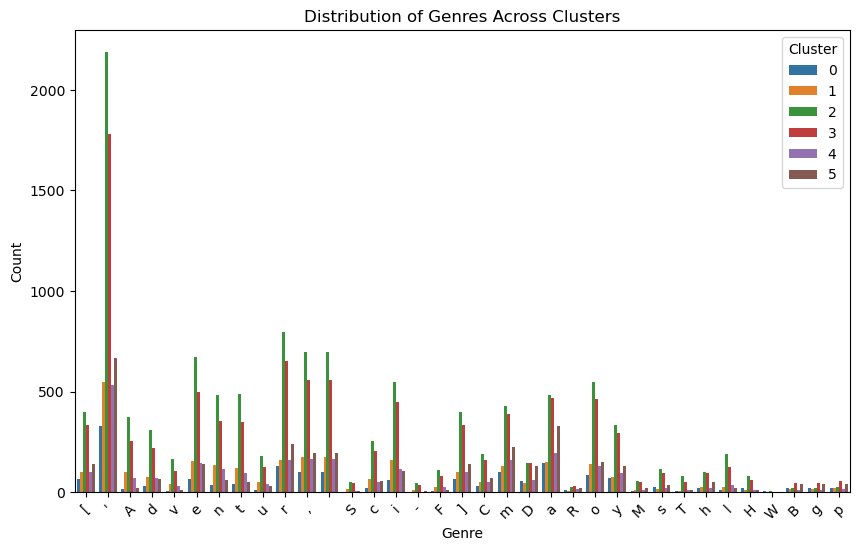

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Create a list of tuples (cluster, genre)
cluster_genre_list = [(cluster, genre) for cluster, genres in zip(ts['cluster'], ts['genre']) for genre in genres]

# Count the occurrences of each (cluster, genre) pair
cluster_genre_count = Counter(cluster_genre_list)

# Convert the Counter object to a DataFrame for plotting
genre_cluster_df = pd.DataFrame(cluster_genre_count.items(), columns=['cluster_genre', 'count'])
genre_cluster_df[['cluster', 'genre']] = pd.DataFrame(genre_cluster_df['cluster_genre'].tolist(), index=genre_cluster_df.index)
genre_cluster_df = genre_cluster_df.drop(columns=['cluster_genre'])

# Plot the distribution of genres across clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_cluster_df, x='genre', y='count', hue='cluster')
plt.title('Distribution of Genres Across Clusters')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()



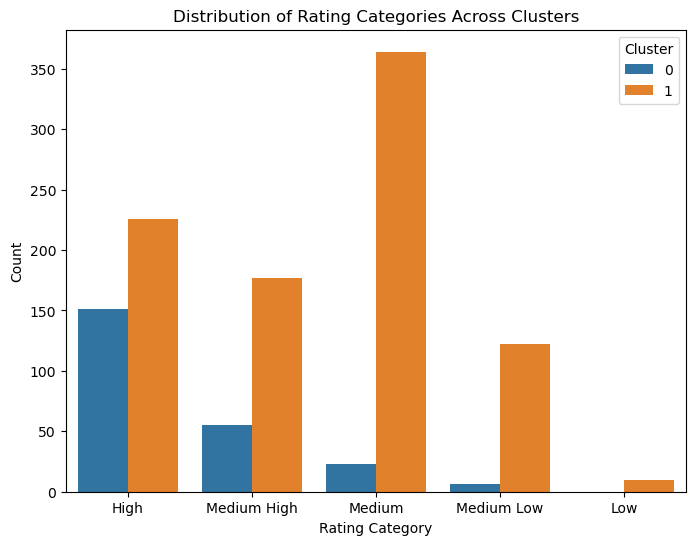

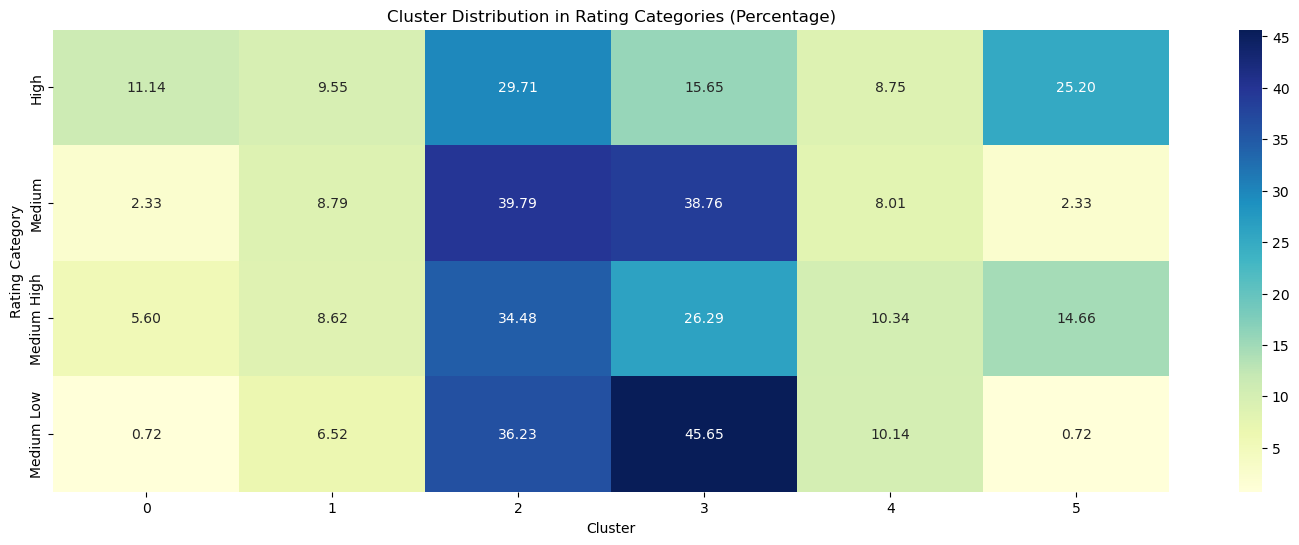


Cluster Purity by Rating Category:
cluster
0    0.562819
1    0.285242
2    0.283800
3    0.361301
4    0.277688
5    0.587329
dtype: float64


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle categorie di rating per cluster
rating_distribution = ts.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)

# Converte i conteggi in percentuali rispetto al totale per ciascuna categoria di rating
rating_distribution_percentage = rating_distribution.div(rating_distribution.sum(axis=1), axis=0) * 100

# Crea la heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(rating_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Cluster Distribution in Rating Categories (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Rating Category')
plt.show()

# Calculate cluster purity for rating category
rating_purity = rating_distribution_percentage.max(axis=0) / rating_distribution_percentage.sum(axis=0)

print("\nCluster Purity by Rating Category:")
print(rating_purity)

In [20]:
rating_purity.mean()

0.39302987375414994

In [21]:
import pandas as pd
from ast import literal_eval

ts_gen = ts

# Convert the genre column from string representation of list to actual list
ts_gen['genre'] = ts_gen['genre'].apply(literal_eval)

# Create a new DataFrame with binary columns for each genre
genres = set(g for sublist in ts_gen['genre'] for g in sublist)
for genre in genres:
    ts_gen[genre] = ts_gen['genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genre column
ts_gen = ts_gen.drop(columns=['genre'])

ts_gen

,id,0,1,2,3,4,5,6,7,8,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,tt0062622,5,5,5,4,3,4,2,3,4,...,0,0,0,1,1,0,0,0,0,0
1,tt0064816,5,5,5,5,2,3,3,3,4,...,0,0,1,0,0,0,0,0,0,0
2,tt0088178,5,5,5,3,3,3,5,5,5,...,0,0,0,0,0,0,1,0,0,0
3,tt0145487,5,2,2,2,1,1,3,5,2,...,0,0,0,1,1,0,0,0,0,0
4,tt0359950,5,5,5,5,5,5,5,5,4,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,5,5,5,4,4,4,4,5,5,...,0,0,0,0,0,0,0,0,0,0
1130,tt9735462,5,5,5,4,5,5,4,5,5,...,1,0,0,0,0,0,0,1,0,0
1131,tt9764362,5,5,5,4,4,4,4,5,5,...,1,0,0,0,0,0,0,0,0,0
1132,tt9784798,5,5,5,3,2,2,3,5,5,...,0,0,0,0,0,0,0,1,0,0


In [22]:

ts_gen.iloc[:, -22:]


,Sport,Horror,Mystery,Romance,Drama,Musical,Thriller,War,History,Action,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1131,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1132,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
ts_gen.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', 'rating', 'rating_category', 'cluster', 'Sport', 'Horror',
       'Mystery', 'Romance', 'Drama', 'Musical', 'Thriller', 'War', 'History',
       'Action', 'Family', 'Music', 'Comedy', 'Fantasy', 'Crime', 'Adventure',
       'Sci-Fi', 'Short', 'Documentary', 'Biography', 'Animation', 'Western'],
      dtype='object')

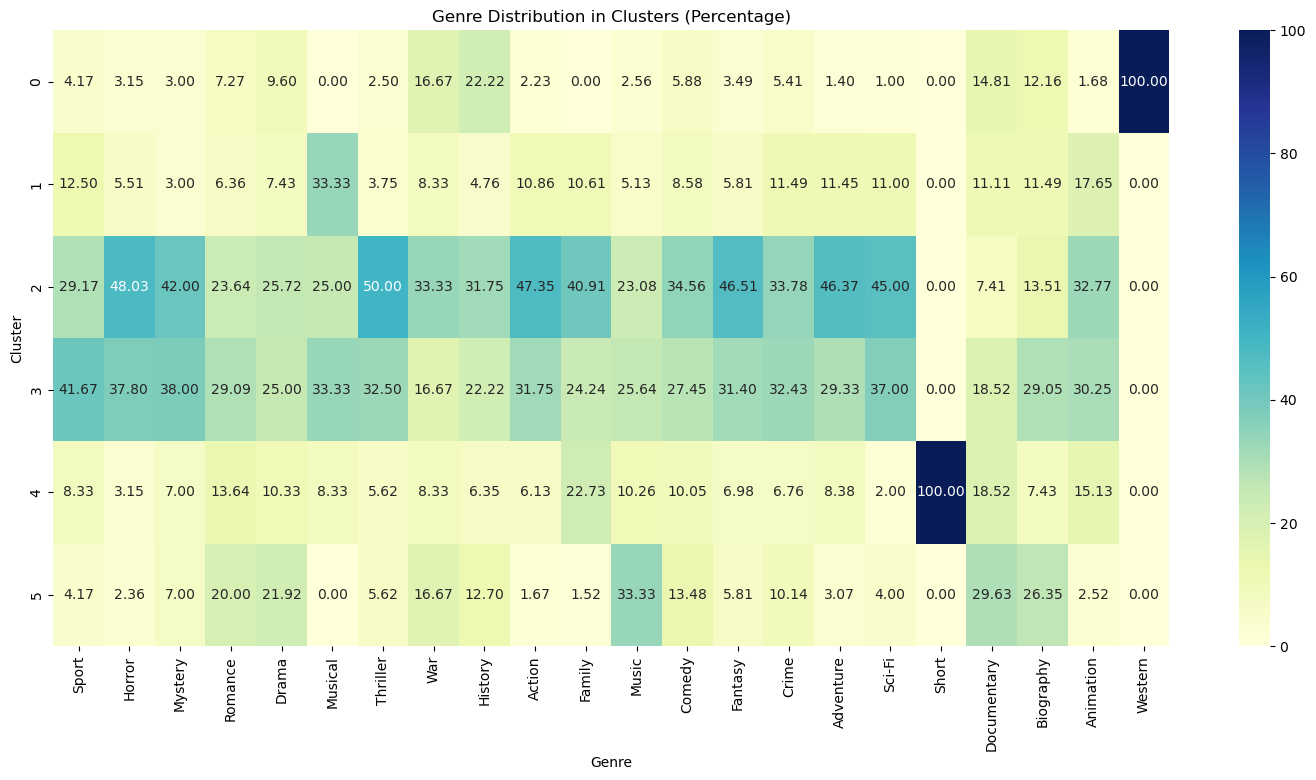

Cluster Purity by Genre:
cluster
0    0.456200
1    0.166537
2    0.073541
3    0.070223
4    0.350339
5    0.150175
dtype: float64


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione dei generi per cluster
genre_columns = ts_gen.columns[-22:]
genre_distribution = ts_gen.groupby('cluster')[genre_columns].sum()

# Converte i conteggi in percentuali rispetto al totale per ciascun genere
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=0), axis=1) * 100

# Crea la heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution in Clusters (Percentage)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

# Calcola la purity per ciascun genere
genre_purity = genre_distribution_percentage.max(axis=1) / genre_distribution_percentage.sum(axis=1)

print("Cluster Purity by Genre:")
print(genre_purity)

In [25]:
genre_purity.mean()

0.21116922023464216

## Feature Based

### TSFresh

#### Without PCA

In [26]:
# !pip install -r requirements.txt

In [27]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [28]:
ts_f = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False, disable_progressbar=True)

# Convertiamo il DataFrame in un array NumPy 3D con forma (n_istanze, 1, n_timepoint)
def convert_to_numpy3D(df):
    return np.expand_dims(df.values, axis=1)

# Applichiamo la conversione
ts_numeric = convert_to_numpy3D(ts_numeric)

ts_ftransform = ts_f.fit_transform(ts_numeric)
ts_ftransform

,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__fourier_entropy__bins_5,var_0__fourier_entropy__bins_10,var_0__fourier_entropy__bins_100,var_0__permutation_entropy__dimension_3__tau_1,var_0__permutation_entropy__dimension_4__tau_1,var_0__permutation_entropy__dimension_5__tau_1,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,var_0__mean_n_absolute_max__number_of_maxima_7
0,1.0,1.0,1.0,1.0,116.0,362.0,0.74,-0.06,0.010204,2.0,...,0.745740,0.999753,2.514981,1.493179,2.476698,2.993215,3.297943,3.503965,0.0,4.571429
1,1.0,1.0,1.0,1.0,115.0,391.0,0.98,-0.02,0.040816,2.0,...,0.847049,1.316945,2.811419,1.532109,2.377441,2.933117,3.335077,3.621823,0.0,5.000000
2,1.0,1.0,1.0,1.0,123.0,379.0,0.46,-0.02,0.020408,2.0,...,0.872990,1.429165,2.758100,0.869049,1.340927,1.713463,2.079252,2.385885,0.0,5.000000
3,1.0,1.0,1.0,1.0,119.0,395.0,1.08,0.00,0.061224,2.0,...,0.515836,0.589280,1.668777,1.274332,2.066594,2.723938,3.191780,3.425356,0.0,5.000000
4,1.0,1.0,1.0,1.0,107.0,351.0,0.20,-0.08,0.000000,1.0,...,0.324508,0.324508,1.535803,0.767204,1.189175,1.520559,1.866561,2.233873,0.0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1.0,1.0,1.0,1.0,108.0,326.0,0.20,-0.04,0.020408,1.0,...,0.324508,0.484390,0.900368,0.793440,1.260998,1.654632,1.905818,2.160632,0.0,4.714286
1130,1.0,1.0,1.0,1.0,115.0,371.0,0.36,-0.04,0.020408,2.0,...,0.163024,0.431071,1.043794,1.135789,1.784884,2.157146,2.348340,2.444419,0.0,5.000000
1131,1.0,1.0,1.0,1.0,109.0,333.0,0.38,-0.06,0.010204,2.0,...,0.589280,0.799059,2.030717,0.994068,1.548138,1.898915,2.373508,2.727542,0.0,4.714286
1132,1.0,1.0,1.0,1.0,105.0,293.0,0.46,-0.06,0.010204,2.0,...,0.535961,0.847049,1.997023,1.155001,1.900468,2.556429,3.101369,3.475342,0.0,4.714286


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ts_fscaled = scaler.fit_transform(ts_ftransform)

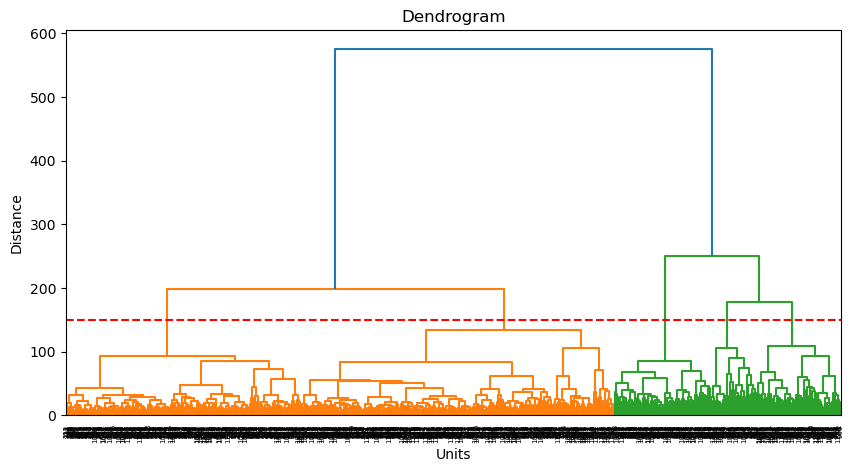

Cluster ottenuti con taglio a 1.5: [5 5 5 ... 2 2 5]


In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Calcolo del linkage
Z = linkage(ts_fscaled, method='ward')

# Visualizzazione del dendrogramma
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Units")
plt.ylabel("Distance")

# Aggiunta della linea orizzontale all'altezza 1.5
plt.axhline(y=150, color='r', linestyle='--')

plt.show()

# Taglio del dendrogramma per ottenere i cluster
clusters_g = fcluster(Z, t= 150, criterion='distance')

# Valutazione dei cluster ottenuti
print(f"Cluster ottenuti con taglio a 1.5: {clusters_g}")

In [31]:
ts_g = ts
ts_g["cluster"] = clusters_g
ts_g

,id,0,1,2,3,4,5,6,7,8,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,tt0062622,5,5,5,4,3,4,2,3,4,...,0,0,0,1,1,0,0,0,0,0
1,tt0064816,5,5,5,5,2,3,3,3,4,...,0,0,1,0,0,0,0,0,0,0
2,tt0088178,5,5,5,3,3,3,5,5,5,...,0,0,0,0,0,0,1,0,0,0
3,tt0145487,5,2,2,2,1,1,3,5,2,...,0,0,0,1,1,0,0,0,0,0
4,tt0359950,5,5,5,5,5,5,5,5,4,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,5,5,5,4,4,4,4,5,5,...,0,0,0,0,0,0,0,0,0,0
1130,tt9735462,5,5,5,4,5,5,4,5,5,...,1,0,0,0,0,0,0,1,0,0
1131,tt9764362,5,5,5,4,4,4,4,5,5,...,1,0,0,0,0,0,0,0,0,0
1132,tt9784798,5,5,5,3,2,2,3,5,5,...,0,0,0,0,0,0,0,1,0,0


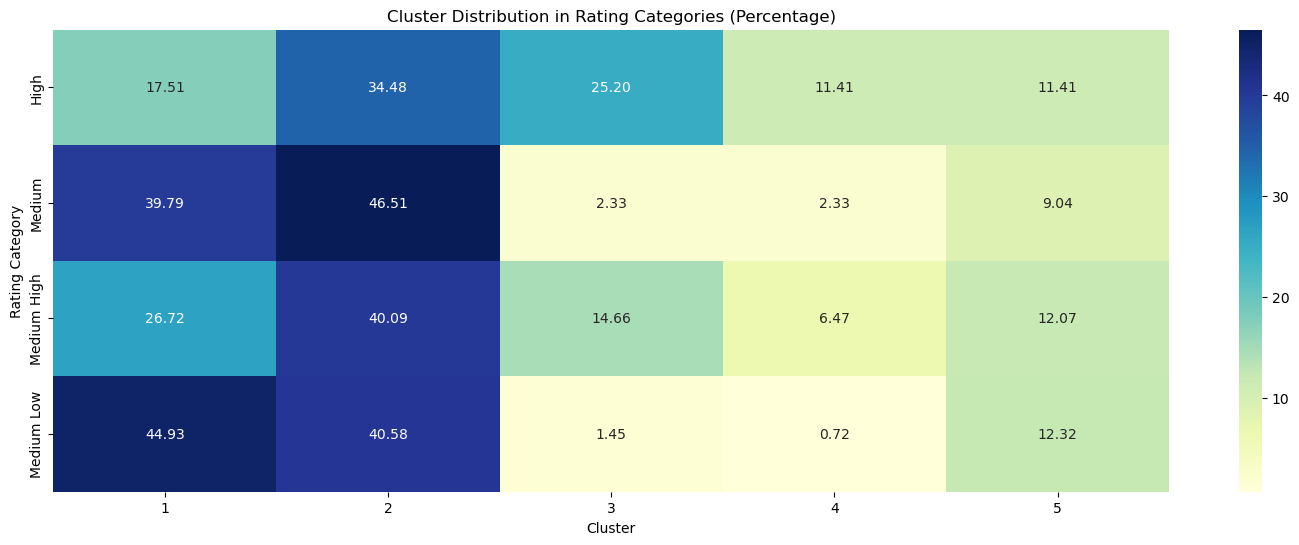


Cluster Purity by Rating Category:
cluster
1    0.348406
2    0.287712
3    0.577574
4    0.545171
5    0.274744
dtype: float64


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle categorie di rating per cluster
rating_distribution = ts_g.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)

# Converte i conteggi in percentuali rispetto al totale per ciascuna categoria di rating
rating_distribution_percentage = rating_distribution.div(rating_distribution.sum(axis=1), axis=0) * 100

# Crea la heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(rating_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Cluster Distribution in Rating Categories (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Rating Category')
plt.show()

# Calculate cluster purity for rating category
rating_purity = rating_distribution_percentage.max(axis=0) / rating_distribution_percentage.sum(axis=0)

print("\nCluster Purity by Rating Category:")
print(rating_purity)

In [33]:
rating_purity.mean()

0.40672133968917407

In [34]:
import pandas as pd
from ast import literal_eval

ts_gen = ts_g

# Convert the genre column from string representation of list to actual list
ts_gen['genre'] = ts_gen['genre'].apply(literal_eval)

# Create a new DataFrame with binary columns for each genre
genres = set(g for sublist in ts_gen['genre'] for g in sublist)
for genre in genres:
    ts_gen[genre] = ts_gen['genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genre column
ts_gen = ts_gen.drop(columns=['genre'])

ts_gen

ValueError: malformed node or string: ['Adventure', 'Sci-Fi']

In [35]:

ts_gen.iloc[:, -22:]


,Sport,Horror,Mystery,Romance,Drama,Musical,Thriller,War,History,Action,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1131,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1132,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
ts_gen.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', 'rating', 'genre', 'rating_category', 'cluster', 'Sport',
       'Horror', 'Mystery', 'Romance', 'Drama', 'Musical', 'Thriller', 'War',
       'History', 'Action', 'Family', 'Music', 'Comedy', 'Fantasy', 'Crime',
       'Adventure', 'Sci-Fi', 'Short', 'Documentary', 'Biography', 'Animation',
       'Western'],
      dtype='object')

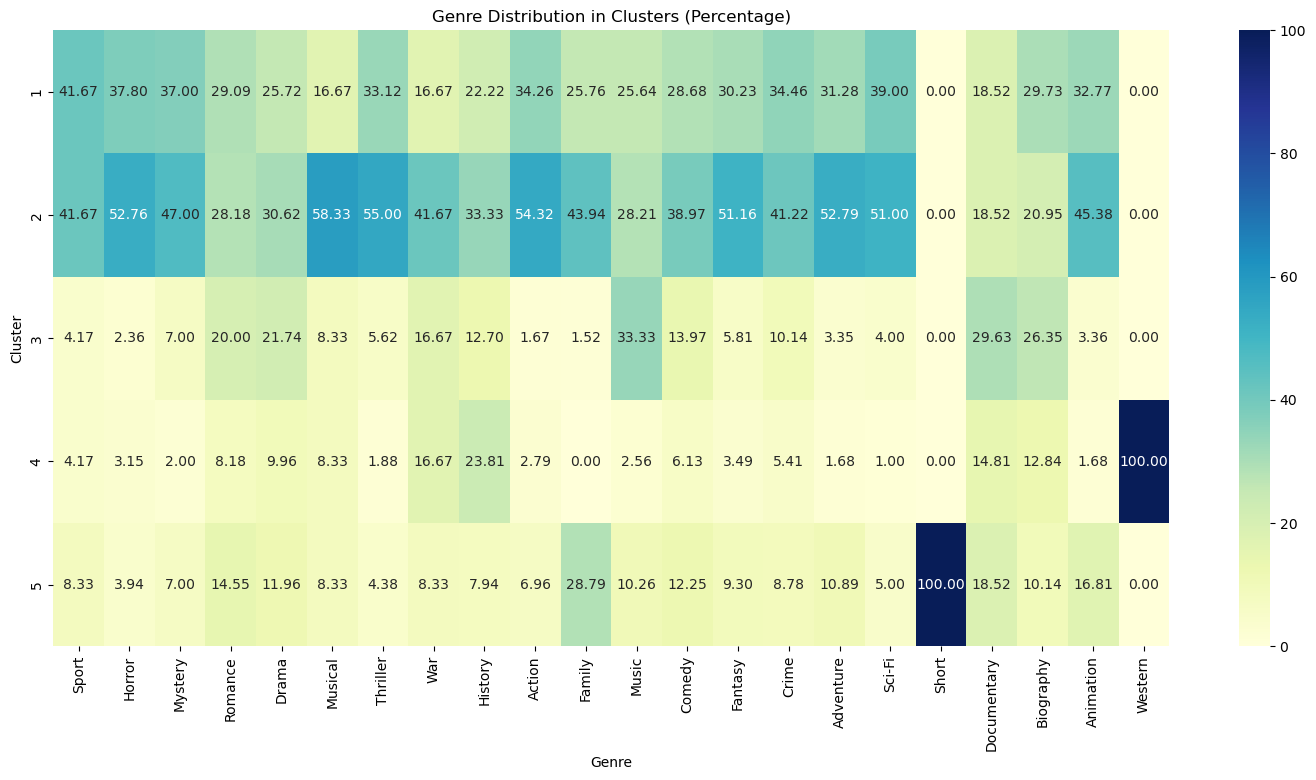

Cluster Purity by Genre:
cluster
1    0.070586
2    0.069860
3    0.143849
4    0.433790
5    0.320047
dtype: float64


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione dei generi per cluster
genre_columns = ts_gen.columns[-22:]
genre_distribution = ts_gen.groupby('cluster')[genre_columns].sum()

# Converte i conteggi in percentuali rispetto al totale per ciascun genere
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=0), axis=1) * 100

# Crea la heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution in Clusters (Percentage)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

# Calcola la purity per ciascun genere
genre_purity = genre_distribution_percentage.max(axis=1) / genre_distribution_percentage.sum(axis=1)

print("Cluster Purity by Genre:")
print(genre_purity)

In [38]:
genre_purity.mean()

0.20762639600975968

### WITH PCA

In [39]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [40]:
ts = pd.read_csv("ts_approx.csv")

ts['rating_category'] = ts['rating_category'].replace('Low', 'Medium Low')

In [41]:
ts_numeric = ts.drop(columns=['id', 'rating', 'genre', 'rating_category'])

train, test = train_test_split(ts_numeric, test_size = 2, random_state = 42)

In [42]:
ts_f = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False, disable_progressbar=True)

# Convertiamo il DataFrame in un array NumPy 3D con forma (n_istanze, 1, n_timepoint)
def convert_to_numpy3D(df):
    return np.expand_dims(df.values, axis=1)

# Applichiamo la conversione
ts_numeric = convert_to_numpy3D(ts_numeric)



In [43]:
ts_ftransform = ts_f.fit_transform(ts_numeric)
ts_ftransform

,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__fourier_entropy__bins_5,var_0__fourier_entropy__bins_10,var_0__fourier_entropy__bins_100,var_0__permutation_entropy__dimension_3__tau_1,var_0__permutation_entropy__dimension_4__tau_1,var_0__permutation_entropy__dimension_5__tau_1,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,var_0__mean_n_absolute_max__number_of_maxima_7
0,1.0,1.0,1.0,1.0,114.0,358.0,0.734694,-0.081633,0.000000,2.0,...,0.745740,1.053072,2.427353,1.509191,2.508146,3.029721,3.336411,3.539859,0.0,4.571429
1,1.0,1.0,1.0,1.0,111.0,375.0,0.918367,-0.102041,-0.010417,2.0,...,0.672296,1.189062,2.671587,1.514455,2.324605,2.891675,3.302130,3.595149,0.0,5.000000
2,1.0,1.0,1.0,1.0,119.0,363.0,0.428571,-0.061224,0.000000,2.0,...,0.773605,1.279615,2.651462,0.881795,1.361382,1.740069,2.111700,2.422493,0.0,5.000000
3,1.0,1.0,1.0,1.0,114.0,370.0,1.040816,-0.061224,0.031250,2.0,...,0.484390,0.745740,1.695071,1.284878,2.085314,2.743474,3.198083,3.425724,0.0,5.000000
4,1.0,1.0,1.0,1.0,106.0,350.0,0.204082,-0.081633,0.000000,1.0,...,0.324508,0.484390,1.589122,0.778376,1.207046,1.543722,1.895172,2.268109,0.0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1.0,1.0,1.0,1.0,105.0,317.0,0.163265,-0.081633,0.000000,1.0,...,0.324508,0.484390,1.043794,0.804611,1.279088,1.679183,1.934412,2.193203,0.0,4.714286
1130,1.0,1.0,1.0,1.0,112.0,362.0,0.326531,-0.081633,0.000000,1.5,...,0.163024,0.431071,1.096104,1.151111,1.809625,2.188258,2.382806,2.481221,0.0,5.000000
1131,1.0,1.0,1.0,1.0,107.0,329.0,0.367347,-0.081633,0.000000,1.5,...,0.642599,0.799059,1.925121,1.007069,1.569448,1.924413,2.405017,2.762418,0.0,4.714286
1132,1.0,1.0,1.0,1.0,103.0,289.0,0.448980,-0.081633,0.000000,2.0,...,0.589280,0.799059,1.943704,1.168705,1.924036,2.586667,3.105663,3.445339,0.0,4.714286


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ts_fscaled = scaler.fit_transform(ts_ftransform)

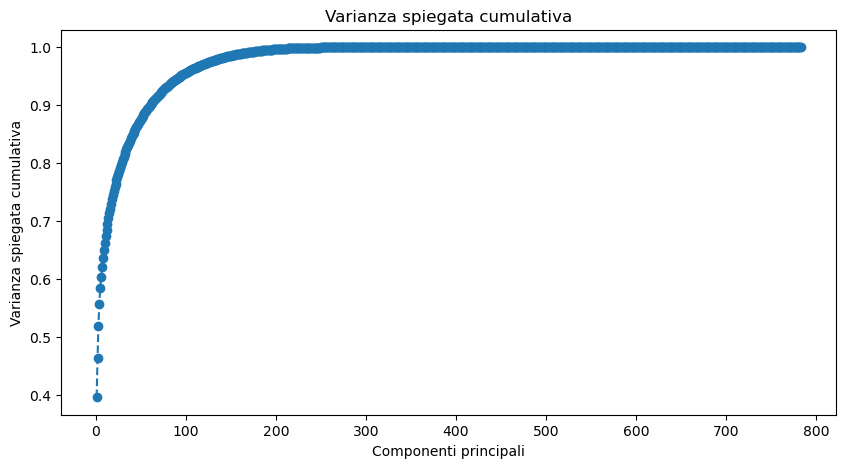

Componente 1: 0.3959
Componente 2: 0.4631
Componente 3: 0.5193
Componente 4: 0.5576
Componente 5: 0.5839
Componente 6: 0.6036
Componente 7: 0.6215
Componente 8: 0.6368
Componente 9: 0.6503
Componente 10: 0.6626
Componente 11: 0.6740
Componente 12: 0.6850
Componente 13: 0.6949
Componente 14: 0.7047
Componente 15: 0.7131
Componente 16: 0.7215
Componente 17: 0.7297
Componente 18: 0.7372
Componente 19: 0.7444
Componente 20: 0.7513
Componente 21: 0.7579
Componente 22: 0.7641
Componente 23: 0.7701
Componente 24: 0.7760
Componente 25: 0.7816
Componente 26: 0.7870
Componente 27: 0.7923
Componente 28: 0.7973
Componente 29: 0.8021
Componente 30: 0.8067
Componente 31: 0.8112
Componente 32: 0.8155
Componente 33: 0.8197
Componente 34: 0.8237
Componente 35: 0.8277
Componente 36: 0.8315
Componente 37: 0.8353
Componente 38: 0.8390
Componente 39: 0.8425
Componente 40: 0.8460
Componente 41: 0.8494
Componente 42: 0.8526
Componente 43: 0.8557
Componente 44: 0.8588
Componente 45: 0.8618
Componente 46: 0.86

In [45]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Esegui PCA
pca = PCA()
ts_pca = pca.fit_transform(ts_fscaled)

# Varianza spiegata per ciascuna componente
explained_variance = pca.explained_variance_ratio_

# Varianza spiegata cumulativa
cumulative_variance = explained_variance.cumsum()

# Grafico della varianza spiegata cumulativa
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza spiegata cumulativa')
plt.xlabel('Componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.show()

# Stampa la varianza spiegata cumulativa
for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: {var:.4f}")

In [46]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Esegui PCA
pca = PCA(n_components=6)
ts_pca = pca.fit_transform(ts_fscaled)

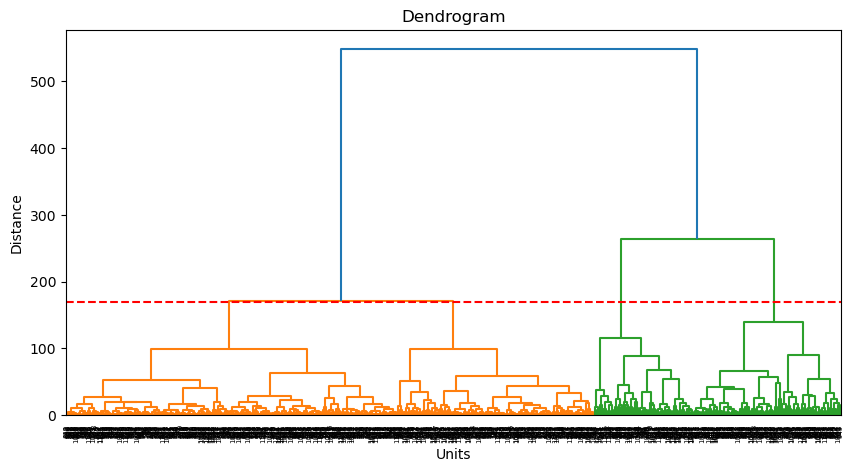

Cluster ottenuti con taglio a 1.5: [3 3 3 ... 1 1 3]


In [47]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Calcolo del linkage
Z = linkage(ts_pca, method='ward')

# Visualizzazione del dendrogramma
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Units")
plt.ylabel("Distance")

# Aggiunta della linea orizzontale all'altezza 1.5
plt.axhline(y=170, color='r', linestyle='--')

plt.show()

# Taglio del dendrogramma per ottenere i cluster
clusters_g = fcluster(Z, t= 170, criterion='distance')

# Valutazione dei cluster ottenuti
print(f"Cluster ottenuti con taglio a 1.5: {clusters_g}")

In [48]:
ts_g = ts
ts_g["cluster"] = clusters_g
ts_g

,id,0,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,rating,genre,rating_category,cluster
0,tt0062622,5,5,5,4,3,4,2,3,4,...,1,1,1,1,1,1,8.3,"['Adventure', 'Sci-Fi']",High,3
1,tt0064816,5,5,5,5,2,3,3,3,4,...,2,4,3,0,1,0,7.1,"['Crime', 'Drama', 'Romance']",High,3
2,tt0088178,5,5,5,3,3,3,5,5,5,...,2,2,2,2,2,2,8.7,"['Documentary', 'Music']",High,3
3,tt0145487,5,2,2,2,1,1,3,5,2,...,4,2,2,2,2,2,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,4
4,tt0359950,5,5,5,5,5,5,5,5,4,...,1,1,1,1,1,1,7.3,"['Adventure', 'Comedy', 'Drama']",High,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,5,5,5,4,4,4,4,5,5,...,1,1,1,1,1,1,6.4,"['Horror', 'Mystery', 'Thriller']",Medium,2
1130,tt9735462,5,5,5,4,5,5,4,5,5,...,1,1,1,1,1,1,6.3,"['Biography', 'Comedy', 'Drama']",Medium,2
1131,tt9764362,5,5,5,4,4,4,4,5,5,...,1,1,1,1,1,1,7.2,"['Comedy', 'Horror', 'Thriller']",High,1
1132,tt9784798,5,5,5,3,2,2,3,5,5,...,1,2,1,1,1,1,7.4,"['Biography', 'Drama', 'History']",High,1


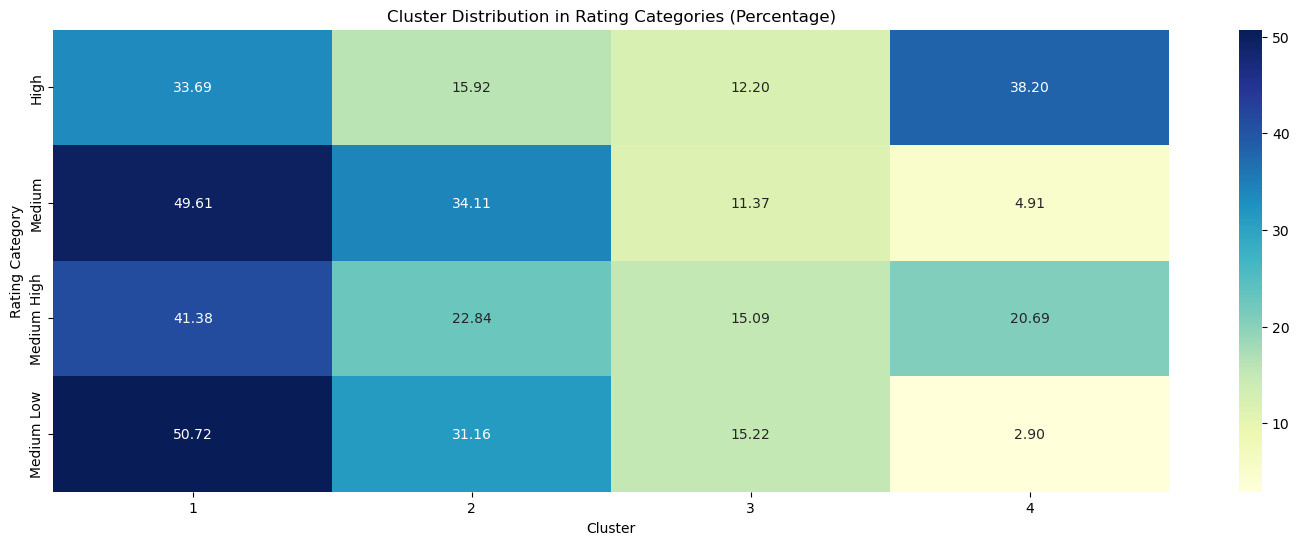


Cluster Purity by Rating Category:
cluster
1    0.289189
2    0.327879
3    0.282459
4    0.572709
dtype: float64


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle categorie di rating per cluster
rating_distribution = ts_g.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)

# Converte i conteggi in percentuali rispetto al totale per ciascuna categoria di rating
rating_distribution_percentage = rating_distribution.div(rating_distribution.sum(axis=1), axis=0) * 100

# Crea la heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(rating_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Cluster Distribution in Rating Categories (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Rating Category')
plt.show()

# Calculate cluster purity for rating category
rating_purity = rating_distribution_percentage.max(axis=0) / rating_distribution_percentage.sum(axis=0)

print("\nCluster Purity by Rating Category:")
print(rating_purity)

In [50]:
rating_purity.mean()

0.36805879546326514

In [51]:
import pandas as pd
from ast import literal_eval

ts_gen = ts_g

# Convert the genre column from string representation of list to actual list
ts_gen['genre'] = ts_gen['genre'].apply(literal_eval)

# Create a new DataFrame with binary columns for each genre
genres = set(g for sublist in ts_gen['genre'] for g in sublist)
for genre in genres:
    ts_gen[genre] = ts_gen['genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genre column
ts_gen = ts_gen.drop(columns=['genre'])

ts_gen

,id,0,1,2,3,4,5,6,7,8,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,tt0062622,5,5,5,4,3,4,2,3,4,...,0,0,0,1,1,0,0,0,0,0
1,tt0064816,5,5,5,5,2,3,3,3,4,...,0,0,1,0,0,0,0,0,0,0
2,tt0088178,5,5,5,3,3,3,5,5,5,...,0,0,0,0,0,0,1,0,0,0
3,tt0145487,5,2,2,2,1,1,3,5,2,...,0,0,0,1,1,0,0,0,0,0
4,tt0359950,5,5,5,5,5,5,5,5,4,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,5,5,5,4,4,4,4,5,5,...,0,0,0,0,0,0,0,0,0,0
1130,tt9735462,5,5,5,4,5,5,4,5,5,...,1,0,0,0,0,0,0,1,0,0
1131,tt9764362,5,5,5,4,4,4,4,5,5,...,1,0,0,0,0,0,0,0,0,0
1132,tt9784798,5,5,5,3,2,2,3,5,5,...,0,0,0,0,0,0,0,1,0,0


In [52]:

ts_gen.iloc[:, -22:]


,Sport,Horror,Mystery,Romance,Drama,Musical,Thriller,War,History,Action,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1131,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1132,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
ts_gen.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', 'rating', 'rating_category', 'cluster', 'Sport', 'Horror',
       'Mystery', 'Romance', 'Drama', 'Musical', 'Thriller', 'War', 'History',
       'Action', 'Family', 'Music', 'Comedy', 'Fantasy', 'Crime', 'Adventure',
       'Sci-Fi', 'Short', 'Documentary', 'Biography', 'Animation', 'Western'],
      dtype='object')

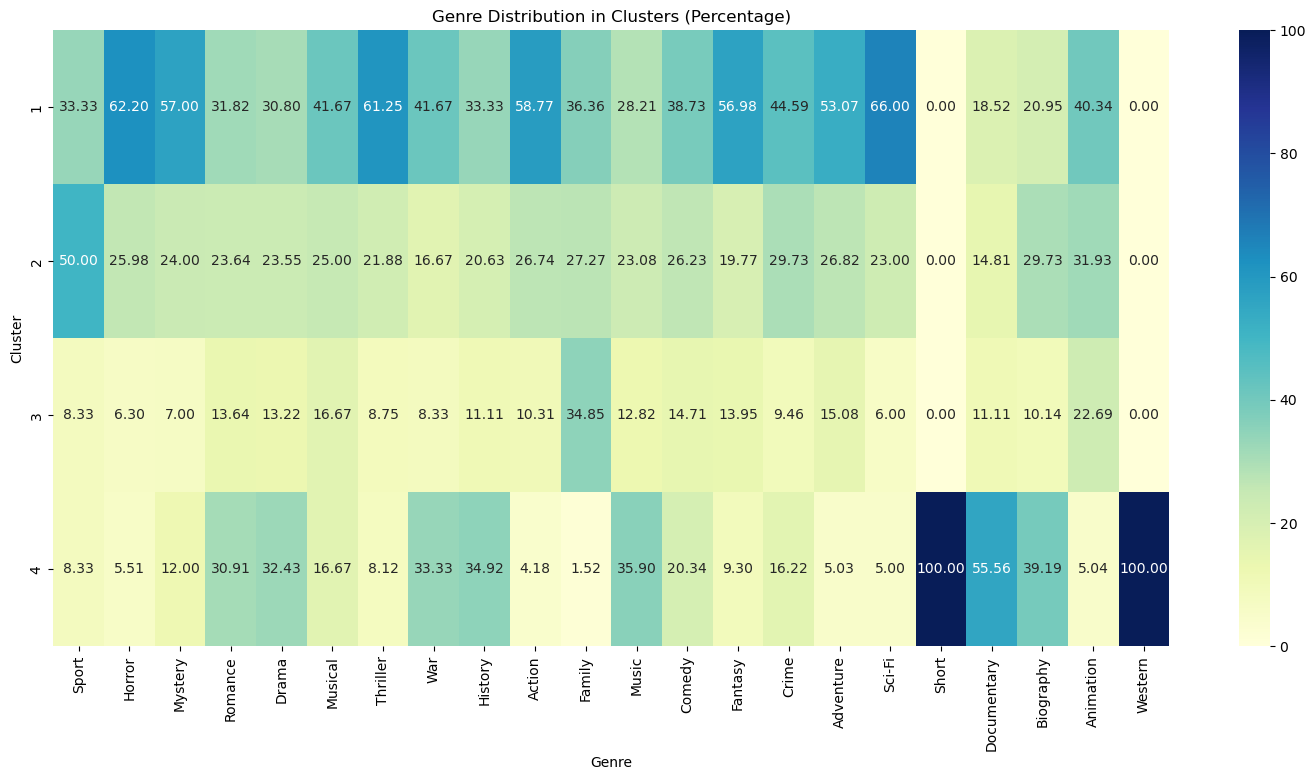

Cluster Purity by Genre:
cluster
1    0.077140
2    0.097952
3    0.136946
4    0.172564
dtype: float64


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione dei generi per cluster
genre_columns = ts_gen.columns[-22:]
genre_distribution = ts_gen.groupby('cluster')[genre_columns].sum()

# Converte i conteggi in percentuali rispetto al totale per ciascun genere
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=0), axis=1) * 100

# Crea la heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution in Clusters (Percentage)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

# Calcola la purity per ciascun genere
genre_purity = genre_distribution_percentage.max(axis=1) / genre_distribution_percentage.sum(axis=1)

print("Cluster Purity by Genre:")
print(genre_purity)

In [55]:
genre_purity.mean()

0.12115073275171932

Con la pca le purity aumentano del 3%.  
  
Anche se clustering con kmeans ha portato a una purity leggermente piu alta comunque sembra che la feature base con pca abbia le classi distribuite meglio all'interno dei cluster.

In [56]:
ts_g

,id,0,1,2,3,4,5,6,7,8,...,Comedy,Fantasy,Crime,Adventure,Sci-Fi,Short,Documentary,Biography,Animation,Western
0,tt0062622,5,5,5,4,3,4,2,3,4,...,0,0,0,1,1,0,0,0,0,0
1,tt0064816,5,5,5,5,2,3,3,3,4,...,0,0,1,0,0,0,0,0,0,0
2,tt0088178,5,5,5,3,3,3,5,5,5,...,0,0,0,0,0,0,1,0,0,0
3,tt0145487,5,2,2,2,1,1,3,5,2,...,0,0,0,1,1,0,0,0,0,0
4,tt0359950,5,5,5,5,5,5,5,5,4,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,5,5,5,4,4,4,4,5,5,...,0,0,0,0,0,0,0,0,0,0
1130,tt9735462,5,5,5,4,5,5,4,5,5,...,1,0,0,0,0,0,0,1,0,0
1131,tt9764362,5,5,5,4,4,4,4,5,5,...,1,0,0,0,0,0,0,0,0,0
1132,tt9784798,5,5,5,3,2,2,3,5,5,...,0,0,0,0,0,0,0,1,0,0


In [57]:
# Calcola la media di ciascuna serie temporale, escludendo le colonne non numeriche
ts_g['mean'] = ts_g.drop(columns=['id', 'rating', 'genre', 'rating_category', 'cluster']).mean(axis=1)

# Statistiche descrittive delle medie delle serie temporali per cluster
cluster_stats_mean = ts_g.groupby('cluster')['mean'].describe()

# Statistiche descrittive del rating per cluster
cluster_stats_rating = ts_g.groupby('cluster')['rating'].describe()

# Visualizza i risultati
print("Statistiche delle medie delle serie temporali per cluster:")
print(cluster_stats_mean)

print("\nStatistiche del rating per cluster:")
print(cluster_stats_rating)

Statistiche delle medie delle serie temporali per cluster:
         count      mean       std       min       25%       50%       75%  \
cluster                                                                      
1        485.0  1.516810  0.049204  1.388889  1.486111  1.513889  1.541667   
2        288.0  1.523196  0.063024  1.375000  1.486111  1.527778  1.559028   
3        146.0  1.630327  0.056133  1.527778  1.583333  1.625000  1.666667   
4        215.0  1.718217  0.069523  1.500000  1.680556  1.708333  1.763889   

              max  
cluster            
1        1.694444  
2        1.708333  
3        1.777778  
4        1.916667  

Statistiche del rating per cluster:
         count      mean       std  min    25%  50%  75%  max
cluster                                                      
1        485.0  6.441856  0.913309  3.1  5.900  6.5  7.1  8.5
2        288.0  6.350347  0.862255  2.8  5.900  6.4  6.9  8.7
3        146.0  6.599315  0.900919  4.3  6.125  6.6  7.2  8.7
4    

In [58]:
cluster_stats_mean

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,485.0,1.516810,0.049204,1.388889,1.486111,1.513889,1.541667,1.694444
2,288.0,1.523196,0.063024,1.375000,1.486111,1.527778,1.559028,1.708333
3,146.0,1.630327,0.056133,1.527778,1.583333,1.625000,1.666667,1.777778
4,215.0,1.718217,0.069523,1.500000,1.680556,1.708333,1.763889,1.916667


In [59]:
cluster_stats_rating

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,485.0,6.441856,0.913309,3.1,5.900,6.5,7.1,8.5
2,288.0,6.350347,0.862255,2.8,5.900,6.4,6.9,8.7
3,146.0,6.599315,0.900919,4.3,6.125,6.6,7.2,8.7
4,215.0,7.212093,0.584090,4.8,6.900,7.3,7.6,8.5
